# 1. Imports

# Hi there!

In [3]:
import pandas as pd # dataframes
import seaborn as sns
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import RobustScaler # scale to zero mean and unit variance
from sklearn.decomposition import PCA # primary component analysis
from sklearn.ensemble import IsolationForest,RandomForestRegressor
import matplotlib.pyplot as plt # plots
from sklearn import set_config # return pd.DataFrame from transformers
import pickle # move transformers and estimators between notebooks
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.neighbors import KNeighborsRegressor
# custom helper functions
from helper_functions import feature_distribution_plot, scree_plot, decision_boundary_plot, imputation_and_accuracy, plot_clustering

<hr> 

# 2. Settings

In [4]:
# set sklearn functions to output pd.DataFrames
set_config(transform_output='pandas')

# plot figures with higher resolutions
plt.rcParams['figure.dpi'] = 150

<hr> 

# 3. Preprocess the Data Set

## 3.1 General Preprocessing

In [5]:
df = pd.read_csv('./data/hcvdat22_Clustering.csv')

Some basic information on the dataset:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  615 non-null    int64  
 1   Age         615 non-null    int64  
 2   Sex         615 non-null    object 
 3   ALB         614 non-null    float64
 4   ALP         597 non-null    float64
 5   ALT         614 non-null    float64
 6   AST         615 non-null    float64
 7   BIL         615 non-null    float64
 8   CHE         615 non-null    float64
 9   CHOL        605 non-null    float64
 10  CREA        615 non-null    float64
 11  GGT         615 non-null    float64
 12  PROT        614 non-null    float64
dtypes: float64(10), int64(2), object(1)
memory usage: 62.6+ KB


- there are 615 rows and 13 columns
- 5/13 columns have duplicate values
- we can drop the duplicate index and the categorical 'sex' column

In [7]:
df.drop(columns=['Unnamed: 0'], inplace=True)

Inspecting some rows of the data:

In [8]:
df.head()

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


## 3.2 Data Distribution

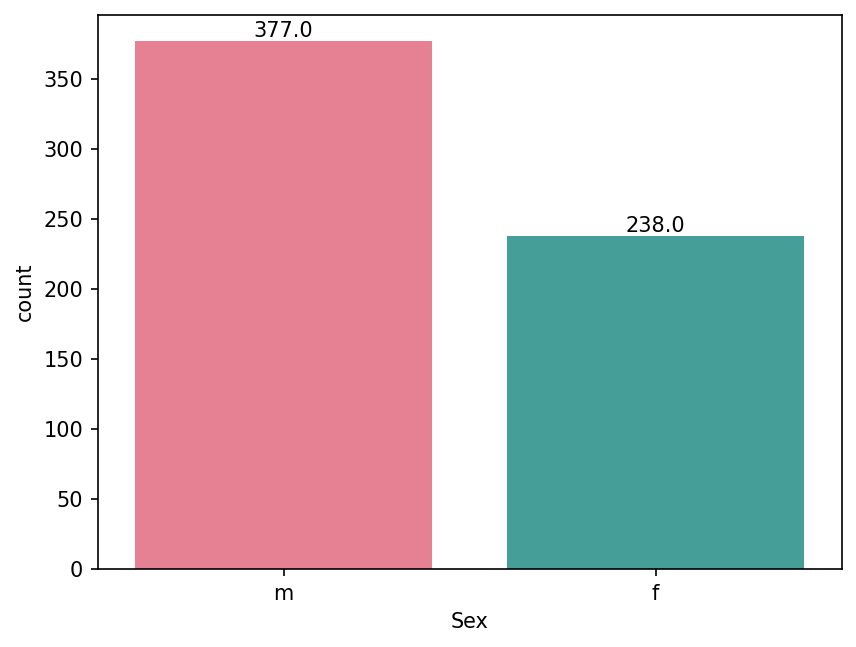

In [9]:
# Set the color palette with two distinct colors
colors = sns.color_palette("husl", 2)

# Create the countplot
ax = sns.countplot(x=df['Sex'], data=df, palette=colors, hue=df['Sex'])

# Add count annotations
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Show the plot
plt.show()

Extract numerical columns

In [10]:
df_numerical = df.select_dtypes(exclude=['object'])
numerical_columns = df_numerical.columns

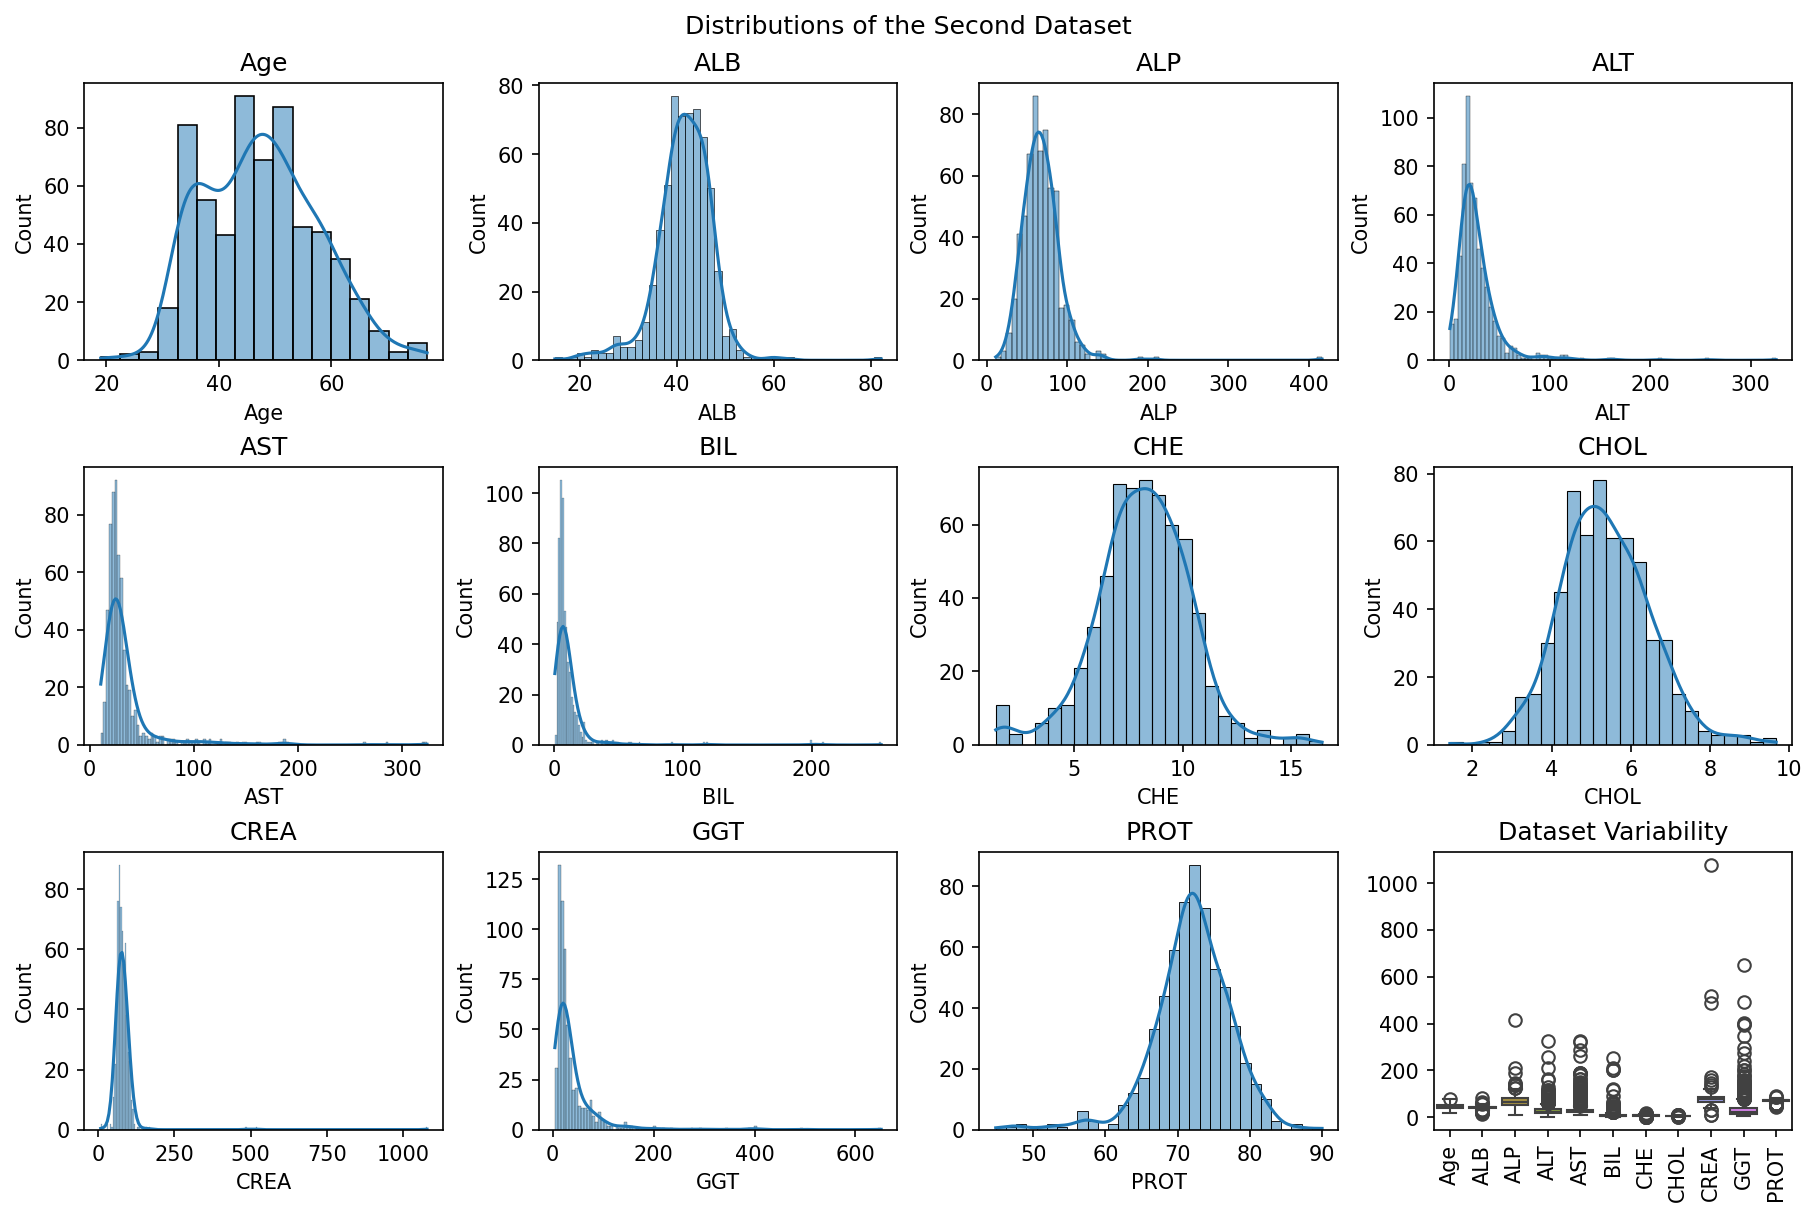

In [11]:
plot_feature_distribution = feature_distribution_plot(df=df[numerical_columns], suptitle='Distributions of the Second Dataset')

Except for age, all features mostly seem to follow a gaussian distribution. However, all features contain outliers which are most noticeable for CREA and GGT. These outliers could represent people for medical conditions  not suitable for blood donation, which we aim to identify.

<hr> 

## 4. Impute Missing Values
- Estimate the accuracy of the imputation for each feature

## 4.1 Show and plot the missing values

How many rows with missing values are there?

In [12]:
na_rows = df[df.isna().any(axis=1)]
len(na_rows)

26

Inspect all 26 rows with missing values:

In [13]:
na_rows

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
121,43,m,48.6,45.0,10.5,40.5,5.3,7.09,NaN,63.0,25.1,70.0
319,32,f,47.4,52.5,19.1,17.1,4.6,10.19,NaN,63.0,23.0,72.2
329,33,f,42.4,137.2,14.2,13.1,3.4,8.23,NaN,48.0,25.7,74.4
413,46,f,42.9,55.1,15.2,29.8,3.6,8.37,NaN,61.0,29.0,71.9
424,48,f,45.6,107.2,24.4,39.0,13.8,9.77,NaN,88.0,38.0,75.1
433,48,f,46.8,93.3,10.0,23.2,4.3,12.41,NaN,52.0,23.9,72.4
498,57,f,48.4,94.4,2.5,39.6,2.3,8.84,NaN,82.0,6.4,76.8
540,38,m,45.0,56.3,NaN,33.1,7.0,9.58,6.0,77.9,18.9,63.0
541,19,m,41.0,NaN,87.0,67.0,12.0,7.55,3.9,62.0,65.0,75.0
545,29,m,49.0,NaN,53.0,39.0,15.0,8.79,3.6,79.0,37.0,90.0


In [14]:
idx_na_rows = na_rows.index

- rows have up to 3/11 NaN values
- 18/26 instances from ALP are NaN
    - keep them because they're only (18/615) ~ 2 % of the original data
- neither columns nor rows get dropped
- missing values get imputed

Show the NAN values for each column

In [15]:
df_nas = df.isnull()
df_nas_sum = df_nas.sum()
print("Sum of NAs in data:")
print(df_nas_sum)

Sum of NAs in data:
Age      0
Sex      0
ALB      1
ALP     18
ALT      1
AST      0
BIL      0
CHE      0
CHOL    10
CREA     0
GGT      0
PROT     1
dtype: int64


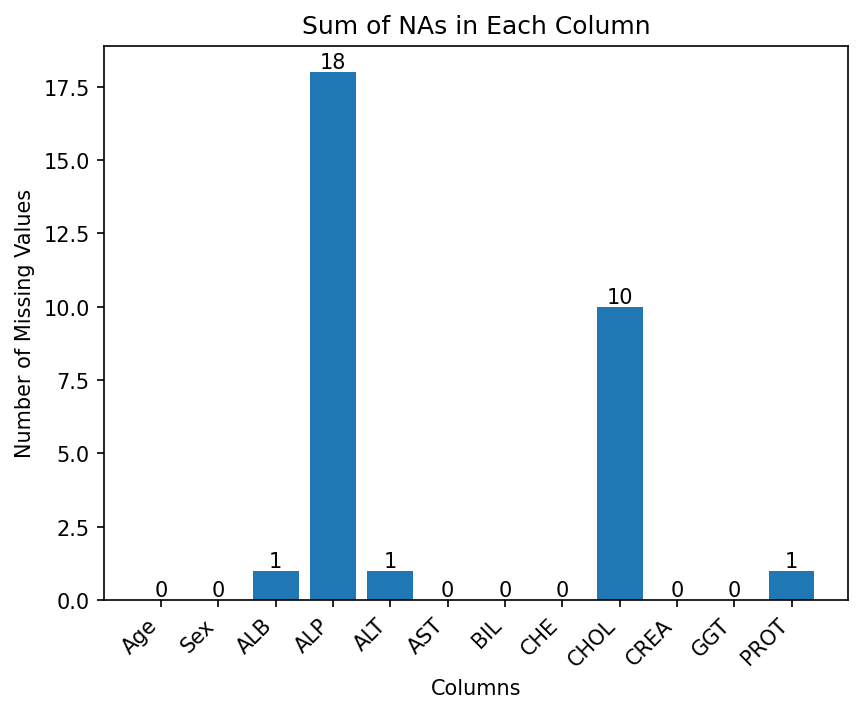

In [16]:
# Plotting the bar chart
fig, ax = plt.subplots()
bars = plt.bar(df_nas_sum.index, df_nas_sum)
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Sum of NAs in Each Column')
plt.xticks(rotation=45, ha='right')  # Rotating x-axis labels for better visibility

# Adding counts on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', color='black')

plt.show()

Extrac all columns containing nan-values

In [17]:
nan_columns = df_nas_sum[df_nas_sum != 0].index

## 4.2 Now impute the missing values using sklearn imputers

Use Label Encoder for column "Sex"

In [18]:
label_encoder = LabelEncoder()
df['Sex'] = label_encoder.fit_transform(df['Sex'])

In [19]:
df_no_nan = df.dropna().copy()

# Split the data into training and test sets
train_data, test_data = train_test_split(df_no_nan, test_size=0.2, random_state=42)

rf_estimator = RandomForestRegressor(n_estimators=10)
knn_estimator = KNeighborsRegressor(n_neighbors=5)

imputer_dict = {
    'mean': SimpleImputer(strategy='mean'),
    'median': SimpleImputer(strategy='median'),
    'iterative_rf': IterativeImputer(estimator=rf_estimator),
    'iterative_knn': IterativeImputer(estimator=knn_estimator),
    'knn': KNNImputer(n_neighbors=5, weights='distance')
}

# Call the function with train and test data
accuracy_results = imputation_and_accuracy(train_data, test_data, nan_columns, imputer_dict)

# Display the accuracy results DataFrame
print("The MSE for each impuation strategy for each column:")
accuracy_results


The MSE for each impuation strategy for each column:


,ALB,ALP,ALT,CHOL,PROT
mean,26.923347,498.483017,480.888634,1.113107,32.533024
median,26.829831,493.51161,492.288305,1.111318,32.209492
iterative_rf,14.853641,491.601392,350.691137,0.905294,21.674568
iterative_knn,20.264122,486.027325,419.573634,1.020859,27.742102
knn,19.939044,480.228482,463.911985,1.029268,27.966236


<hr>

## As seen in the dataframe the iterative imputer with the a random forest estimator has the smallest MSE, but w choose to continue our work with the KNN Imputer, due to the fact that the iterative imputer is still an experimental estimator.

## 4.3 Perform actual Imputation

In [20]:
iterative_imputer_rf = imputer_dict["knn"]# TODO: either add indicator or save missing_indicator separately
df_imputed = iterative_imputer_rf.fit_transform(df)

Are there any missing values left?

In [21]:
len(df_imputed[df_imputed.isna().any(axis=1)])

0

<hr>

## 5. Scaling
Scale the features to zero mean and unit variance using a robust scaling approach to control for the effect of outliers and different scales:

In [22]:
scaler = RobustScaler() # instantiate scaler
df_imputed = df_imputed.drop(columns=["Sex"], axis=1) # should not be used for the scaling and isolation forest
df_scaled = scaler.fit_transform(df_imputed) # fit the scaler create scaled data

Inspect the scaled features:

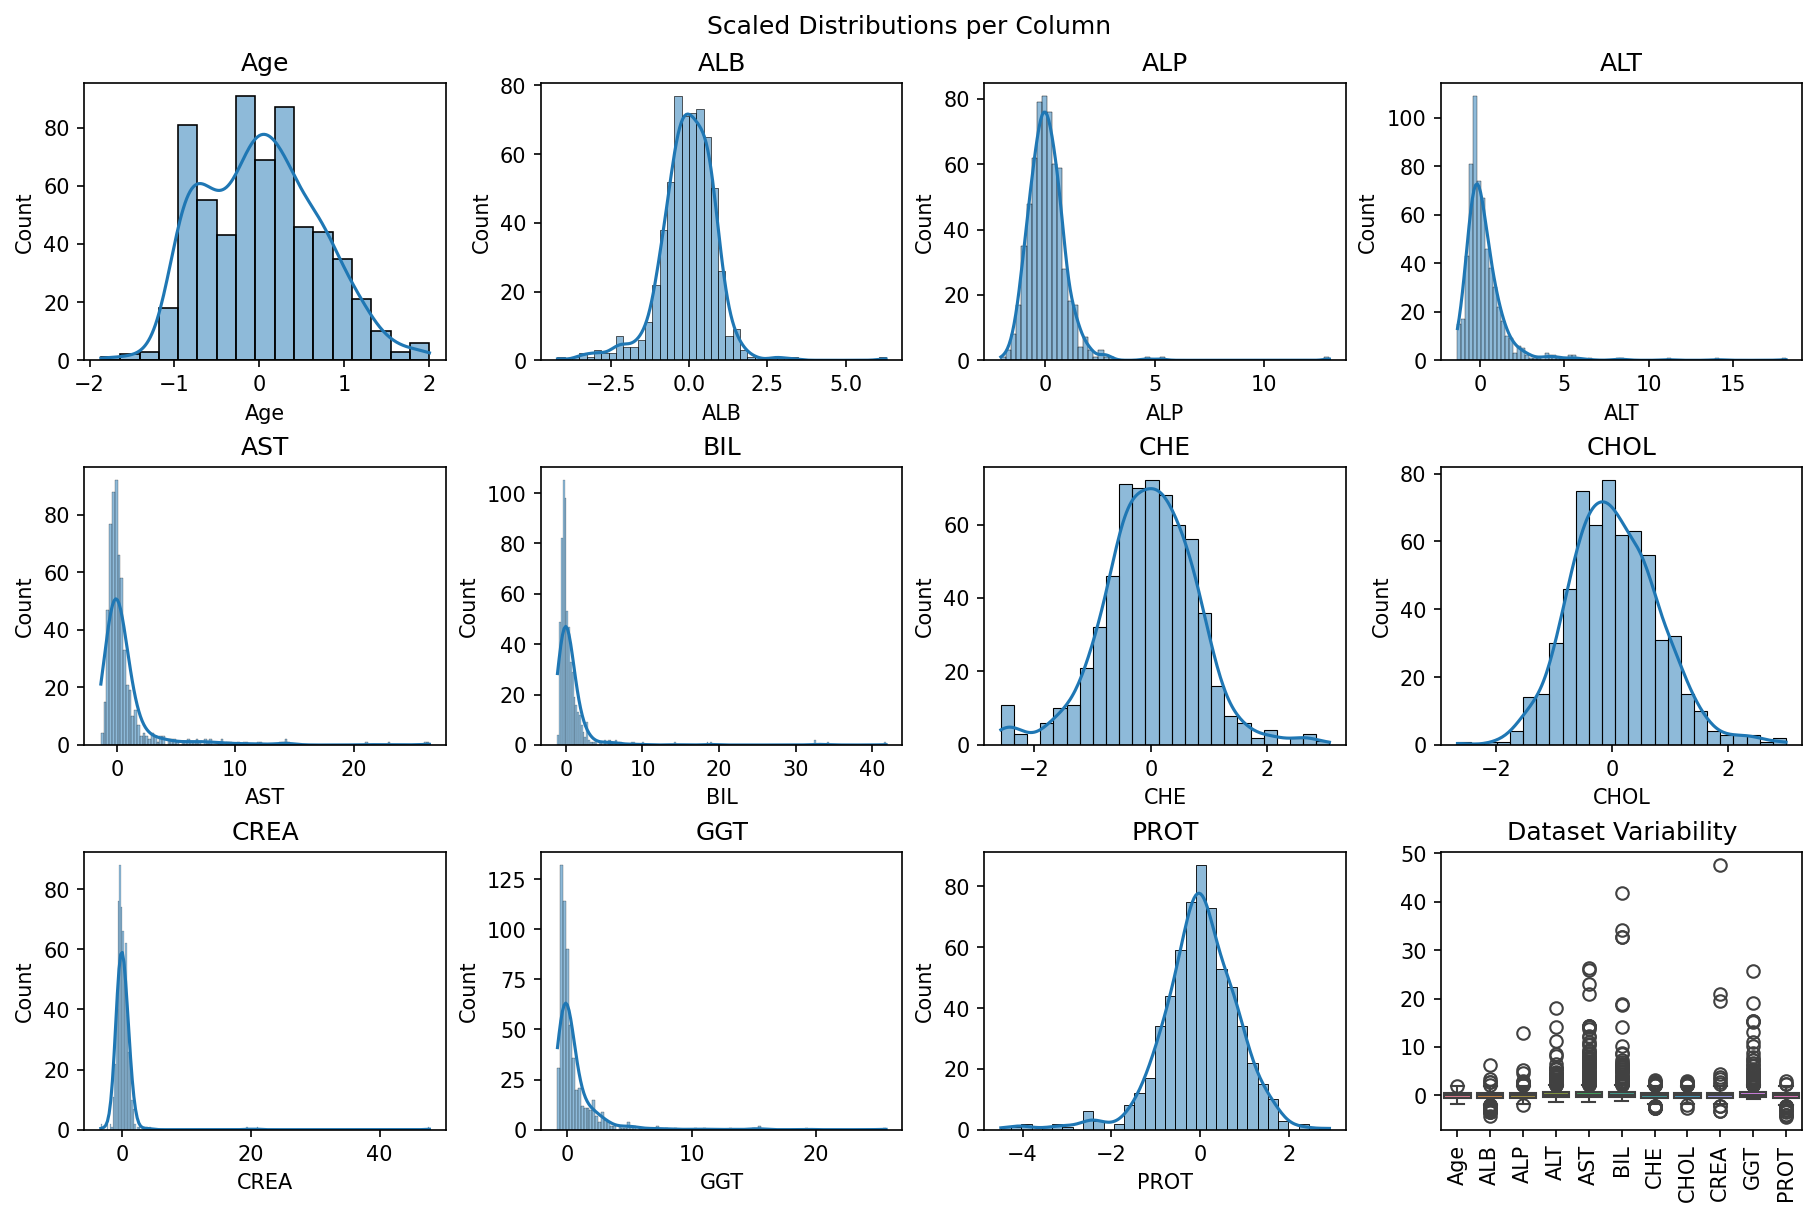

In [23]:
plot_feature_distribution_scaled = feature_distribution_plot(df=df_scaled[numerical_columns], suptitle='Scaled Distributions per Column')

The distributions look the same but in the dataset variability plot, we can observe how the scale has narrowed down significantly, making the pca less susceptible to outliers.

# Principal Component Analysis
- Transform the data into the principal components from phase one
- Would it make sense to retrain the PCA for the new data?
    - Yes, since the PCA is dependant on the data's distribution which has changed between phases one and two

## Using the original (old) PCA

In [24]:
# import the pca from phase one
with open('./pickle/pca_phase_one.pkl', 'rb') as file:
    pca_phase_one = pickle.load(file)

In [25]:
df_pca_phase_one = pca_phase_one.transform(df_scaled)

## Training a new PCA

In [26]:
N_COMPONENTS = 11
pca_phase_two = PCA(n_components=N_COMPONENTS)

In [27]:
df_pca_phase_two = pca_phase_two.fit_transform(df_scaled)

## Comparing Principal Components

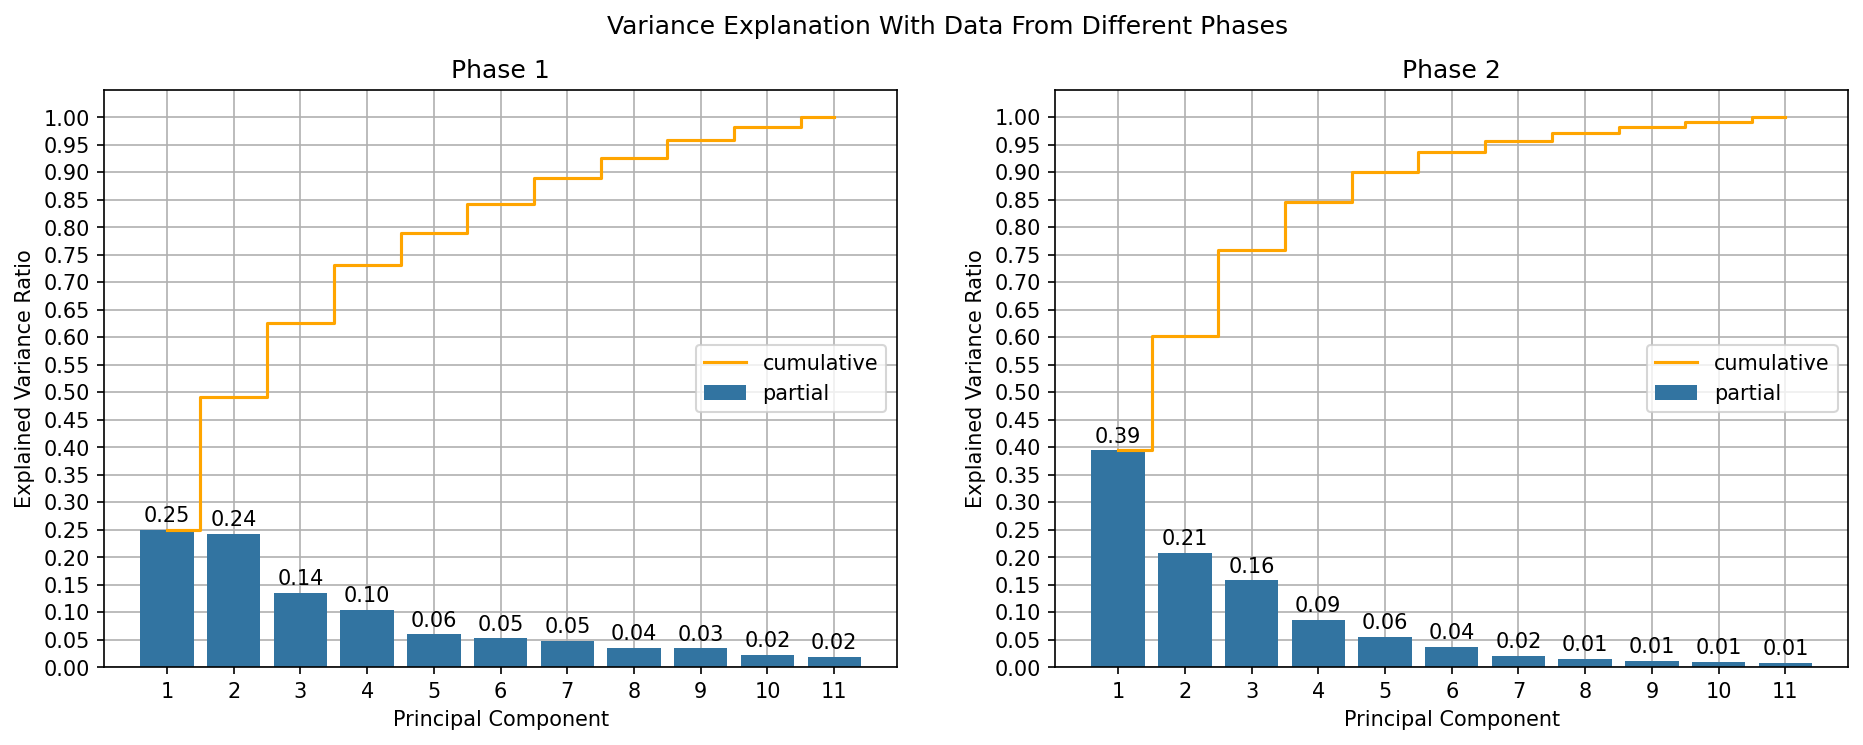

In [28]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

scree_plot(ax1, pca_phase_one, 'Phase 1')
scree_plot(ax2, pca_phase_two, 'Phase 2')

plt.suptitle('Variance Explanation With Data From Different Phases')

plt.show()

# Perform a Cluster Analysis
-Compare and discuss the results of the Anomaly Detection & Cluster Analysis

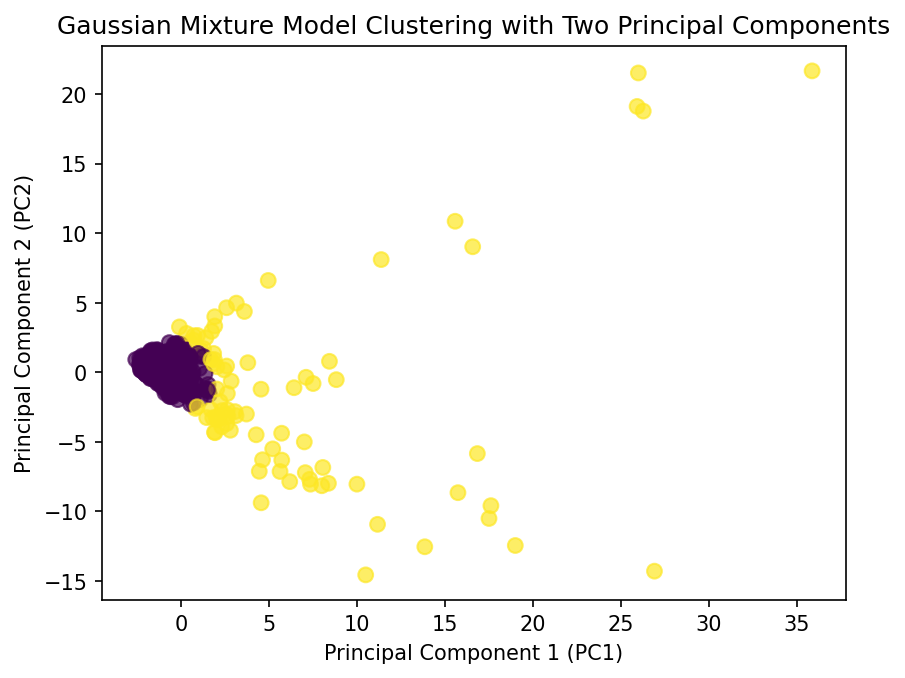

In [34]:
plot_clustering(df_pca_phase_two)

Here we have two clusters, purple and yellow. 
We assume that the purple dots/cluster are those which don't have any anomaly and the yellow dots/cluster show anomalies. We can see that the yellow dots are not really centered around (0|0) and are spreadall over both axis

In [29]:
# import the fitted isolation forest
with open('./pickle/isolation_forest_phase_one.pkl', 'rb') as file:
    isolation_forest_phase_one = pickle.load(file)

In [30]:
first_two_pcs_new = df_pca_phase_two.iloc[:,:2]
predictions = isolation_forest_phase_one.predict(first_two_pcs_new)
df_pca_phase_two['outlier'] = predictions

In [31]:
df_pca_phase_two

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,outlier
0,-1.454404,1.049683,1.074791,-1.139169,-1.112942,0.798079,-1.199553,0.585644,0.851503,-0.167827,-0.291031,1
1,-1.882372,0.138840,-0.346785,-0.374212,-0.174016,-0.486668,0.115804,0.324989,1.241970,-0.766253,-0.884657,1
2,0.134664,-1.572784,-0.048761,-1.073428,0.671103,-1.245228,-0.197577,0.888491,0.487722,-0.410503,0.164923,1
3,0.198815,1.599611,-0.063994,0.206295,0.492597,-0.419897,-1.191972,0.333357,0.335670,-0.530827,0.062141,1
4,-0.831908,0.422940,-0.163006,0.200287,0.253489,0.693210,-0.364893,0.397963,1.244975,-0.061380,-0.142703,1
...,...,...,...,...,...,...,...,...,...,...,...,...
610,17.610388,-9.593258,4.129371,19.292081,-6.934884,-0.828360,4.302144,4.916986,1.331816,0.204706,0.628599,-1
611,1.894155,0.915073,-0.866760,-0.301110,-2.378227,2.605234,0.450096,1.850355,-1.343358,-1.038357,-1.053854,1
612,8.434026,0.784074,-1.377488,-1.820383,-1.976588,0.255960,0.470153,1.641249,-1.796558,-1.416098,-1.099974,-1
613,2.847816,-0.641625,-1.707897,-0.629129,-0.263152,1.532958,-0.815224,0.490401,-0.562857,-0.811554,0.042327,1


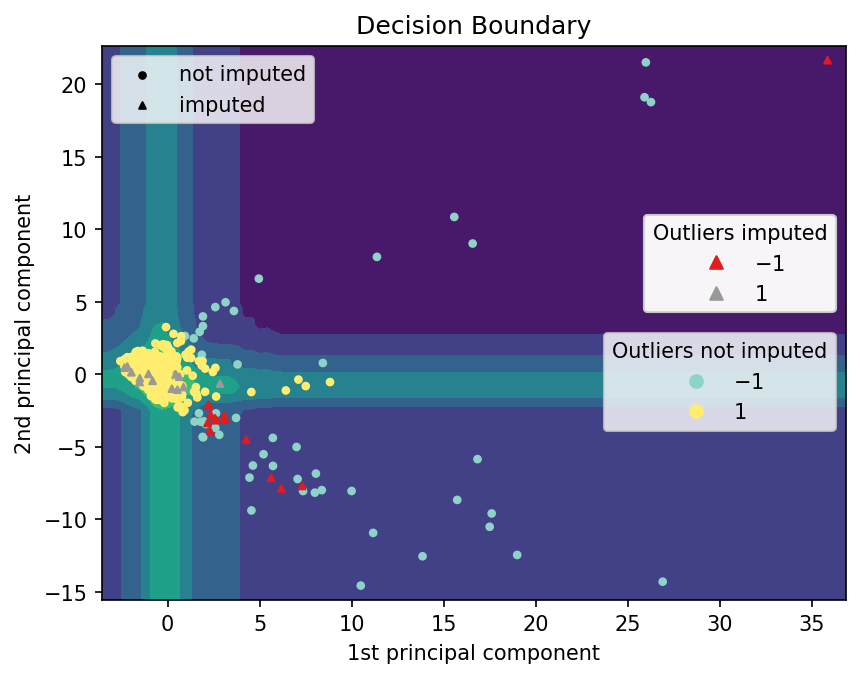

In [33]:
plot_decision_boundary = decision_boundary_plot(df=df_pca_phase_two, estimator=isolation_forest_phase_one, imputed_rows=idx_na_rows)

The figure demonstrates the first two principal components plottet against each other. Non-imputed datapoints are shown as circles, with inliers colored yellow and outliers colored blue. Imputed datapoints are shown as triangles, with inliers colored grey and outliers colored red. The two turquoise-colored vectors parallel to the plot's axes are the decision boundaries, based on which the decision tree classifies a given datapoint as in- oder outlier.

Notice how the main cluster of inliers is roughly located at a value of zero for both principal components, hinting on how these values may encode normality. Principal component one almost only includes positive values, while principal component two includes values from +20 down to -15. Inliers mostly stay within a range of ± 5 for both principal components with the exception of five datapoints classified as inliers with a value of +10 for principal component one. Outliers are located close to two diagonal vectors that spread out from the main cluster of inliners. Only one imputed values has a positive value for principal component two, while the rest takes on negative values. 

When trying to guess what kind of information the principal components cover, one can look at their ranges. As principal component one only spans positive values, it may encode the degree to which a datapoint's values diverge from one that would be considered as 'healthy' by the algorithm. Principal component two may support this and encode whether overall values are rather too low or too high.

## Discussion

Comparing both plots we see that the anomaly detection have declare more data points being anomalies compared to the 